In [38]:
import os
import random
import pandas as pd
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import matplotlib.pyplot as plt

In [9]:
env_id = 'CarRacing-v2'
render_mode = "rgb_array"

env = DummyVecEnv([lambda: gym.make(env_id, render_mode=render_mode)])

In [11]:
env.observation_space.shape

(96, 96, 3)

In [4]:
# List all subfolders in the folder
models_subfolder = [f.path for f in os.scandir(env_id) if f.is_dir()]

# Choose a random subfolder
random_model_subfolder = random.choice(models_subfolder)

files = [f.path for f in os.scandir(random_model_subfolder) if f.is_file()]

random_file = random.choice(files)
random_file

'CarRacing-v2/model_11/seed_945351111358374057.parquet'

In [37]:
# Read the Parquet file into a DataFrame
df = pd.read_parquet(random_file)
df['observation'] = df.apply(lambda row : row["observation"].reshape(env.observation_space.shape), axis = 1)
df

,observation,rewards,action
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",847.019775,"[-0.091807306, 1.0, 0.15434468]"
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",840.497253,"[-1.0, 0.0, 0.0]"
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",840.597290,"[0.14005792, 0.0, 0.0]"
3,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",840.697266,"[-1.0, 0.8609494, 0.0]"
4,"[[[100, 202, 100], [100, 202, 100], [100, 212,...",840.797241,"[-0.76116765, 1.0, 0.0]"
...,...,...,...
995,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.500000,"[0.31994113, 0.858278, 0.0]"
996,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.400000,"[-0.85577756, 0.0, 0.0]"
997,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.300000,"[0.5071352, 1.0, 0.0]"
998,"[[[100, 202, 100], [100, 202, 100], [100, 202,...",-0.200000,"[-0.6658039, 1.0, 0.001861453]"


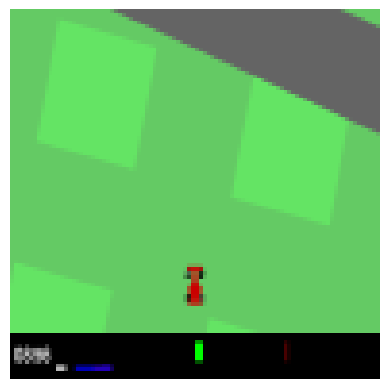

(-8.900002, array([0.6915356, 0.       , 0.       ], dtype=float32))

In [53]:
random_row = random.randint(0, len(df))
plt.imshow(df["observation"][random_row])
plt.axis('off')  # Turn off axis labels
plt.show()
df["rewards"][random_row], df["action"][random_row]